In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set_style('whitegrid')

In [4]:
column_names = [
    'id',
    'label',
    'statement',
    'subject',
    'speaker',
    'job_title',
    'state_info',
    'party_affiliation',
    'barely_true_counts',
    'false_counts',
    'half_true_counts',
    'mostly_true_counts',
    'pants_on_fire_counts',
    'context'
]

# Read the TSV files into pandas DataFrames
# use sep = \t because it is a TSV not csv
train_df = pd.read_csv("train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv("test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv("valid.tsv", sep='\t', names=column_names)

print(f"Shape of the training set: {train_df.shape}")
print(f"Shape of the test set: {test_df.shape}")
print(f"Shape of the validation set: {valid_df.shape}")

Shape of the training set: (10240, 14)
Shape of the test set: (1267, 14)
Shape of the validation set: (1284, 14)


In [5]:
# combine all 3 dataframes ONLY for EDA (to get a better overall idea of data)
# add a source column to keep track of what dataframe is row is from
train_df['source_set'] = 'train'
test_df['source_set'] = 'test'
valid_df['source_set'] = 'valid'

# Concatenate the three dataframes into one
liar_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)

# Display the shape and first few rows of the combined dataframe
print(f"\nShape of the combined dataset: {liar_df.shape}")
print("\nFirst 5 rows of the combined dataset:")
liar_df.head()


Shape of the combined dataset: (12791, 15)

First 5 rows of the combined dataset:


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,source_set
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,train
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,train
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,train
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,train
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,train


In [6]:
# check data types, nulls
print("--- Data Types and Null Value Check (.info()) ---")
liar_df.info()

print("\n" + "="*50 + "\n") # A separator for cleaner output

# use .describe() to get basic stats on numerical columns (8-12)
print("--- Summary Statistics for Numerical Columns (.describe()) ---")
liar_df.describe()

--- Data Types and Null Value Check (.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12791 non-null  object 
 1   label                 12791 non-null  object 
 2   statement             12791 non-null  object 
 3   subject               12789 non-null  object 
 4   speaker               12789 non-null  object 
 5   job_title             9223 non-null   object 
 6   state_info            10040 non-null  object 
 7   party_affiliation     12789 non-null  object 
 8   barely_true_counts    12789 non-null  float64
 9   false_counts          12789 non-null  float64
 10  half_true_counts      12789 non-null  float64
 11  mostly_true_counts    12789 non-null  float64
 12  pants_on_fire_counts  12789 non-null  float64
 13  context               12660 non-null  object 
 14  source_set          

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000
mean,11.583939,13.359059,17.185785,16.497850,6.251388
std,18.978037,24.140086,35.847678,36.165276,16.180777
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


**Data types and Null takeaways**


*   12791 entries
*   columns (0-7, 13-14) are object types, and (8-12) are numerical. This lines up with the titles, where all 'counts' columns are numerical

*   The job_title column is missing about 3500 entries, with state_info missing about 2,700 entries. *update these columns in future*

*   Context column is missing 130, we can just remove these rows or figure out what to do in future.

*   A few other columns have a couple missing datapoints, but nothing serious.


**Summary Statistics Takeaway - AI generated, update before submit**

*   Right-Skewed Distributions: For all five credit history columns, the mean is much larger than the median (the 50% mark). This indicates a strong right-skewed distribution. In simple terms, most speakers have a low count of prior statements, while a few prolific speakers have a very high count, pulling the average up.

*   Presence of Outliers: The large difference between the 75th percentile and the max value confirms the presence of outliers. For example, 75% of speakers have 15 or fewer prior "false" statements, but one speaker has 114.

*   Many New Speakers: The 25th percentile (25%) for every category is 0. This means that at least 25% of the entries are from speakers who have no recorded history in any of the truthfulness categories in this dataset. They are essentially "new" speakers.
---





--- Counts of Each Label ---
label
half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: count, dtype: int64


/tmp/ipython-input-158303257.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=liar_df, order=label_order, palette='viridis')


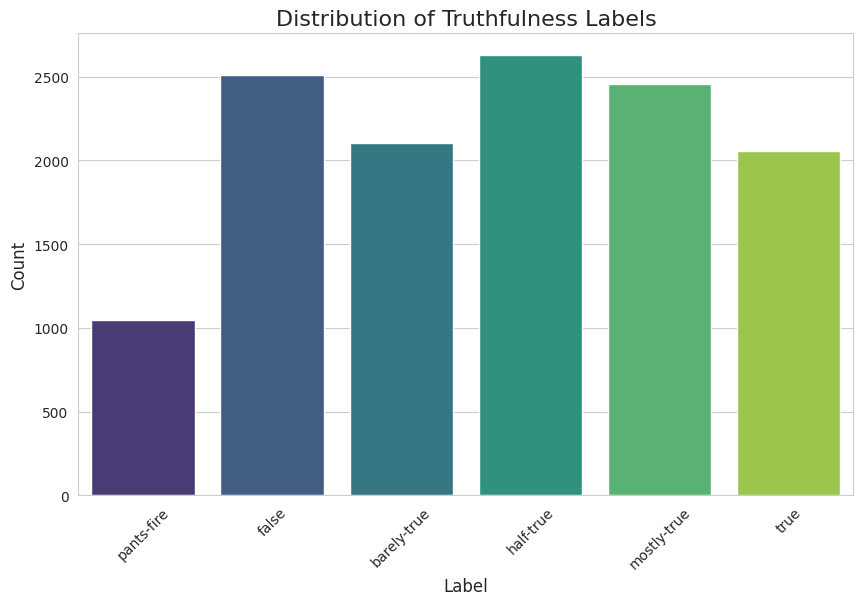

In [8]:
# Analyze target variable
label_counts = liar_df['label'].value_counts()

print("--- Counts of Each Label ---")
print(label_counts)

# bar graph of total target variable counts
plt.figure(figsize=(10, 6))

label_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
sns.countplot(x='label', data=liar_df, order=label_order, palette='viridis')

# add titles and labels
plt.title('Distribution of Truthfulness Labels', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels to prevent overlap

plt.show()

We check the totals of the target variables to make sure there is not a huge class imbalance, which can lead to biases or inaccuracies in our models.

In this dataset, all of the labels are fairly equal other than the pants-fire label, which is about half the count of the others. To account for this, we can use a technique like oversampling that label (creating additional copies) during the model training phase, or adding additional data from other databases that would match our pants-fire label.

--- Top 10 Party Affiliations ---
party_affiliation
republican      5665
democrat        4137
none            2181
organization     264
independent      180
newsmaker         64
libertarian       51
journalist        49
activist          45
columnist         44
Name: count, dtype: int64


/tmp/ipython-input-589414251.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


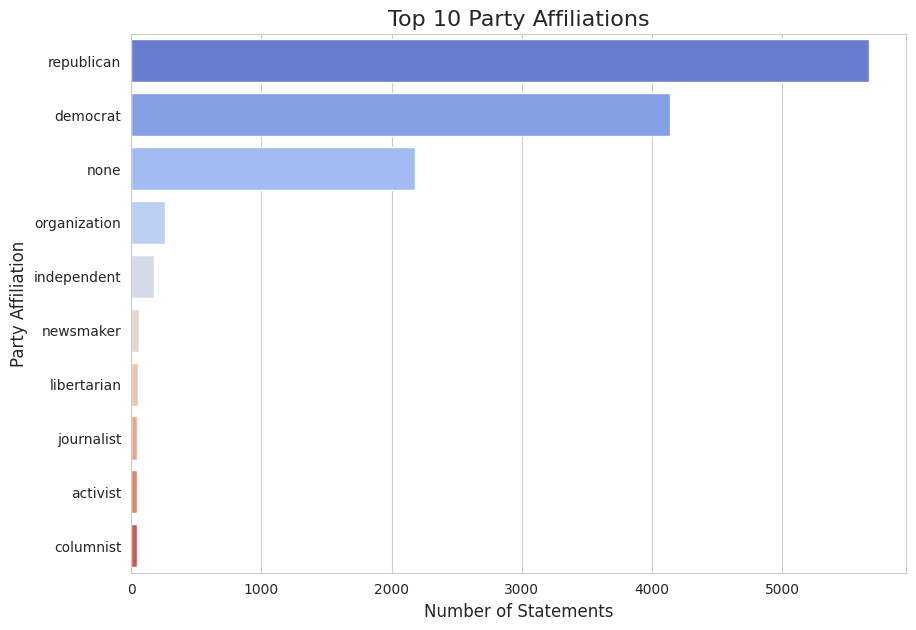


--- Top 10 Speakers ---
speaker
barack-obama       611
donald-trump       343
hillary-clinton    297
mitt-romney        212
john-mccain        189
scott-walker       183
chain-email        178
rick-perry         173
marco-rubio        153
rick-scott         150
Name: count, dtype: int64


/tmp/ipython-input-589414251.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


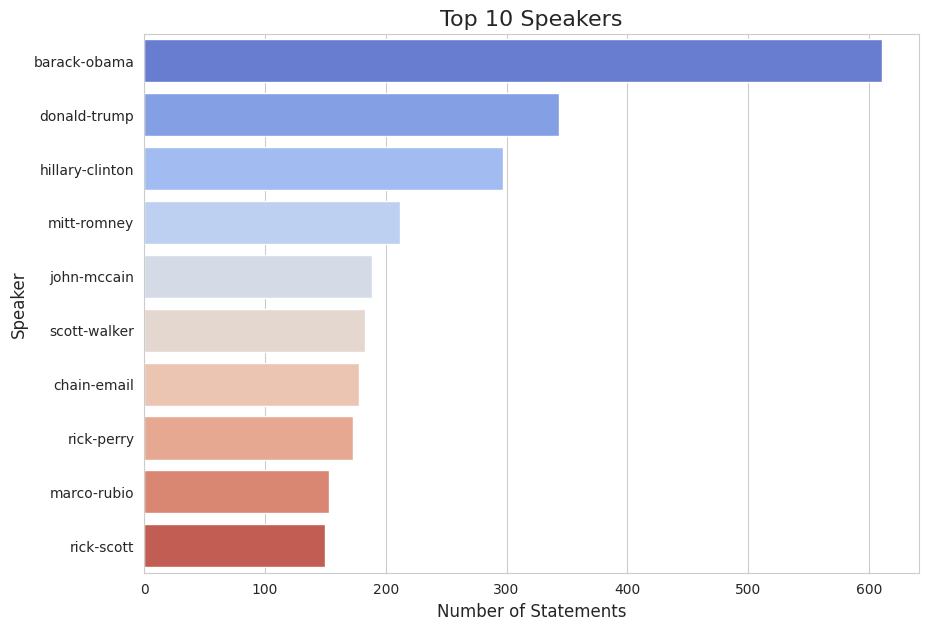


--- Top 10 Subjects ---
subject
health-care             474
taxes                   356
education               309
elections               304
immigration             303
candidates-biography    239
economy                 170
guns                    152
economy,jobs            152
federal-budget          152
Name: count, dtype: int64


/tmp/ipython-input-589414251.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)


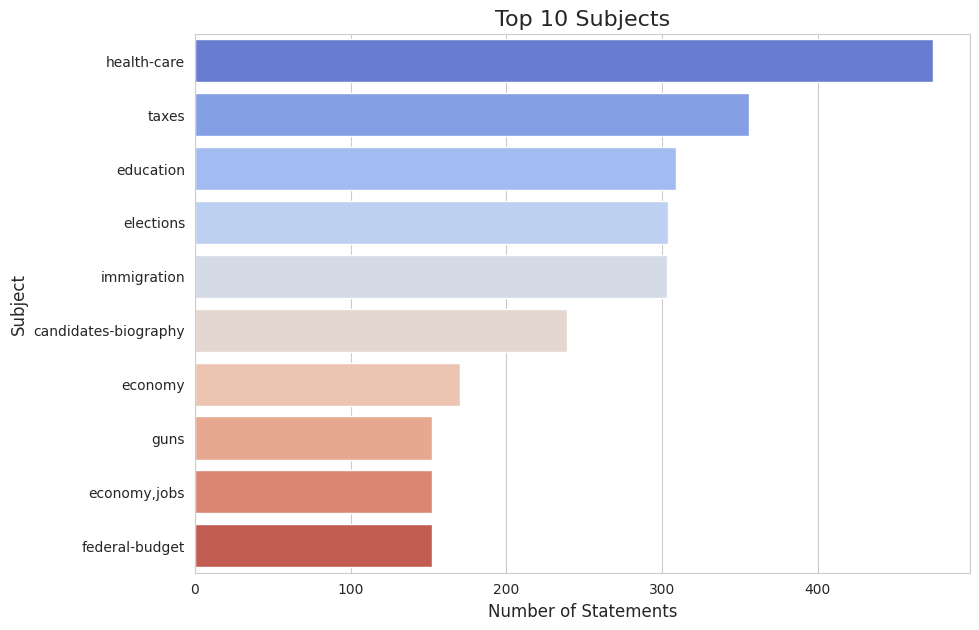

In [10]:
custom_palette = sns.color_palette("coolwarm", 10)
def plot_top_categories(df, column, title, n=10):
    """Counts and plots the top N most frequent categories in a column."""
    counts = df[column].value_counts().head(n)

    plt.figure(figsize=(10, 7))
    sns.barplot(x=counts.values, y=counts.index, palette=custom_palette)

    plt.title(title, fontsize=16)
    plt.xlabel('Number of Statements', fontsize=12)
    plt.ylabel(column.replace('_', ' ').title(), fontsize=12)
    plt.show()

# party affiliations
print("--- Top 10 Party Affiliations ---")
print(liar_df['party_affiliation'].value_counts().head(10))
plot_top_categories(liar_df, 'party_affiliation', 'Top 10 Party Affiliations')

# speakers
print("\n--- Top 10 Speakers ---")
print(liar_df['speaker'].value_counts().head(10))
plot_top_categories(liar_df, 'speaker', 'Top 10 Speakers')

# subject
print("\n--- Top 10 Subjects ---")
print(liar_df['subject'].value_counts().head(10))
plot_top_categories(liar_df, 'subject', 'Top 10 Subjects')

*possibly update the chart colors to match party (red for republican, blue for democrat, green for independent?)*

add more insights from data here

/tmp/ipython-input-2506945701.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=liar_df, order=label_order, palette='plasma')


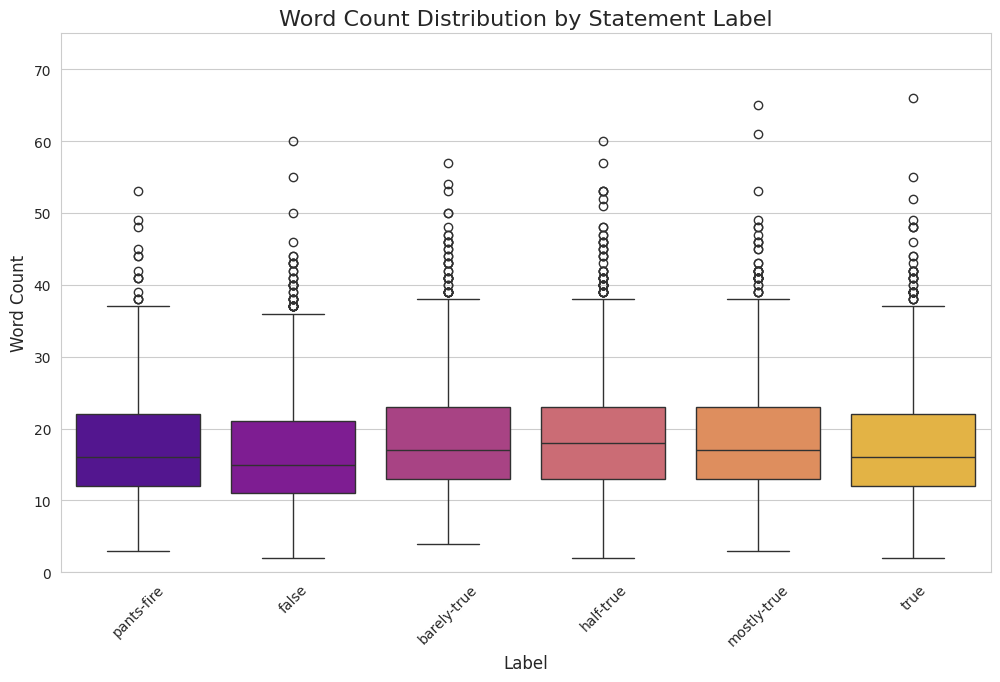

In [11]:
# analyze statement length
liar_df['word_count'] = liar_df['statement'].apply(lambda x: len(str(x).split()))

# box plots separated by label
plt.figure(figsize=(12, 7))
sns.boxplot(x='label', y='word_count', data=liar_df, order=label_order, palette='plasma')

plt.title('Word Count Distribution by Statement Label', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 75) # Limiting y-axis to see the box plots more clearly
plt.show()


add insights from data here

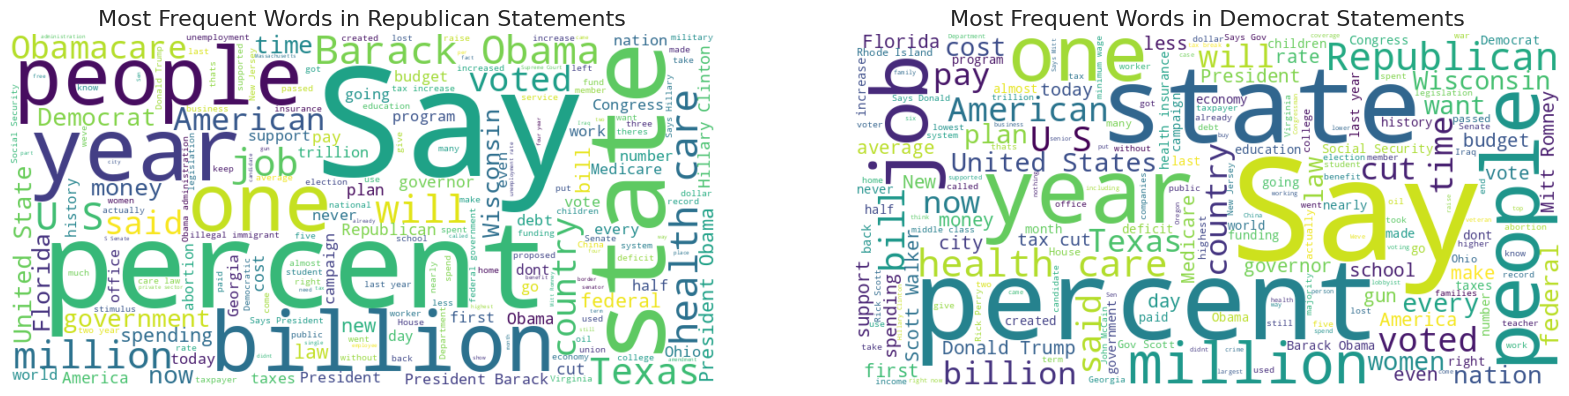

In [20]:
# word clouds!
# calc word counts
liar_df['word_count'] = liar_df['statement'].apply(lambda x: len(str(x).split()))

# separate words by party
republican_text = ' '.join(liar_df[liar_df['party_affiliation'] == 'republican']['statement'].dropna())
democrat_text = ' '.join(liar_df[liar_df['party_affiliation'] == 'democrat']['statement'].dropna())

# create clouds
wc_republican = WordCloud(width=800, height=400, background_color='white').generate(republican_text)
wc_democrat = WordCloud(width=800, height=400, background_color='white').generate(democrat_text)

# plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wc_republican, interpolation='bilinear')
axes[0].set_title('Most Frequent Words in Republican Statements', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wc_democrat, interpolation='bilinear')
axes[1].set_title('Most Frequent Words in Democrat Statements', fontsize=16)
axes[1].axis('off')

plt.show()